# Basic RNN

![](./tensorflow-seq2seq-tutorials/pictures/1-seq2seq.png)

# Implementation

* Length issues:
    * Static Unrolling: multiple graphs with different time lengths and separate the dataset into different buckets.
    * Dynamic Unrolling: use control flow opts to process sequence step by step. relative to static one, dynamic type allows different lengths, require less space and therefore more efficient (more fast.)

# Vocabulary

First, we will reconstruct the sequence into another integer-based sequence.

Input data consists of sequences of integers.

In [1]:
x = [[10, 20, 21], [6, 4], [10, 20], [3]]

The sequence above is convenient to the human, but rnn prefers another type as below.

In [2]:
import sys
sys.path.append("tensorflow-seq2seq-tutorials")

import helpers

In [3]:
xt, xlen = helpers.batch(x)

In [4]:
x

[[10, 20, 21], [6, 4], [10, 20], [3]]

In [5]:
xt

array([[10,  6, 10,  3],
       [20,  4, 20,  0],
       [21,  0,  0,  0]])

In [6]:
xt.shape

(3, 4)

Shape of the matrix stands for `[max_time, batch_size]`. Sequences shorter than the longest one are padded with '0' toward to the end. Such layer is called `time-major`.

In [7]:
xlen   # represents for the time series

[3, 2, 2, 1]

# Building the Model

## Encoder
* Starts with empty state.
* Run through the input sequence.
* Not interested in encoder's output, but its `final_state`.

## Decoder
* Use encoder's `final_state` as its `initial_state`.
* The `input` are a batch-sized matrix with `<EOS>` token at the first time step.
* The `output` are mapped onto the output space in `[hidden_units, output_vocab_size]` projection layer. `hidden_units` is like the intelligence. `output_vocab_size` represents the target space growing with the size of the dictionary.
    
Such type of encoder-decoder is forced to learn fixed-length representation (specificially to the size of  `hidden_units`) of the variable-length input sequence and restore output sequence only from this representation.

In [8]:
import numpy as np
import tensorflow as tf
import helpers

tf.reset_default_graph()
sess = tf.InteractiveSession()

In [9]:
print("Tensorflow version: {}".format(tf.__version__))

Tensorflow version: 1.11.0


## Vocabulary size

Dynamic RNN models can be adapted to (1) different batch size, (2) sequence length without retraining. For example, load serializing paramters and graph definitions via `tf.train.Saver`. But, changing vocabulary size (here, the size is the space for the whole target words.) requires a retraining.

In [10]:
PAD = 0
EOS = 1

vocab_size = 10
input_embeddning_size = 20

encoder_hidden_units = 20
decoder_hidden_units = encoder_hidden_units

## Inputs


* `encoder_inputs`: a **int32** tensor shaped [encoder_max_time, batch_size]
* `decoder_targets`: a **int32** tensor shaped [decoder_max_time, batch_size]

In [11]:
encoder_inputs = tf.placeholder(shape=(None, None), dtype=tf.int32, name="encoder_inputs")
decoder_targets = tf.placeholder(shape=(None, None), dtype=tf.int32, name="decoder_targets")

* (Add an additional placeholder tensor) `decoder_inputs`: a **int32** tensor shaped [decoder_max_time, batch_size]

In [12]:
decoder_inputs = tf.placeholder(shape=(None, None), dtype=tf.int32, name="decoder_inputs")

We don't need to feed `decoder_inputs` manually. They are a function of either `decoder_targets` or previous decoder outputs during rollout.

During training, `decoder_inputs` will consist of `<EOS>` token concatenated with `decoder_targets` along time axis.

Notice that all shapes are specificied with `None`s (means `dynamically`). We can use batches of any size with any numbers of timesteps. But there are serveral constraints:

* Feed values for the whole tensor should have the same `batch_size`.
* Decoder `inputs` (decoder_inputs) and `outputs` (decoder_targets) should have the same `decoder_max_time`.

## Embeddings

Encoder and decoder RNNs expect dense vector representation of words, e.g. `[max_time, batch_size, input_embedding_size]`. We can convert one to another by using `embeddings`.

We rely on end-to-end training to learn vector representation for words jointly with encoder and decoder.

In [13]:
embeddings = tf.get_variable("embeddings", \
        dtype=tf.float32, \
        shape=[vocab_size, input_embeddning_size], \
        initializer=tf.random_uniform_initializer(-1.0, 1.0))

We use `tf.nn.embedding_lookup` to index embedding matrix; if we given word 4, it means 4th column of the embedding matrix. Wy only need to compute gradients at 4th column.

In the case, the encoder and decoder share the same embedding. (In real NLP applications, embedding matrix can be very large.)

In [14]:
encoder_input_embedded = tf.nn.embedding_lookup(embeddings, encoder_inputs)
decoder_input_embedded = tf.nn.embedding_lookup(embeddings, decoder_inputs)

## Encoder

In [15]:
encoder_cell = tf.contrib.rnn.LSTMCell(encoder_hidden_units)

# _ is the encoder output, but here we don't need
_, encoder_final_state = tf.nn.dynamic_rnn(encoder_cell, encoder_input_embedded, dtype=tf.float32, time_major=True)

`encoder_final_state` is the state of LSTM's hidden cells at the last moment of the Encoder rollout. `encoder_final_state` is also called `thought vector`. We use it as the input of the decoder. It is the only input to the decoder in the model without attention mechanism.

In [16]:
encoder_final_state

LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_3:0' shape=(?, 20) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_4:0' shape=(?, 20) dtype=float32>)

Tensorflow LSTM implementation stores state as the a tuple of tensors.
* `encoder_final_state.h`: activation of hidden layer of LSTM cell
* `encoder_final_state.c`: final output

## Decoder

In [17]:
decoder_cell = tf.contrib.rnn.LSTMCell(decoder_hidden_units)

decoder_outputs, decoder_final_state = tf.nn.dynamic_rnn(decoder_cell, decoder_input_embedded, \
                                                         initial_state=encoder_final_state, dtype=tf.float32, \
                                                        time_major=True, scope="plain_decoder")

`initial_state=encoder_final_state` requires:
* the same cell type (here is LSTMCell)
* the same amount of `hidden_units`
* the same amount of layers (single layer)

In [18]:
decoder_outputs

<tf.Tensor 'plain_decoder/TensorArrayStack/TensorArrayGatherV3:0' shape=(?, ?, 20) dtype=float32>

`decoder_outpute` is a `hidden_units` sized vector at every timestep. For training or prediction we need logits of size `vocab_size`. Here we have to put linear layer (fc layer without activation function) on top of LSTM output to get non-normalized logits. This layer is called projection layer by convention.

In [19]:
decoder_logits  = tf.contrib.layers.linear(decoder_outputs, vocab_size)
decoder_prediction = tf.argmax(decoder_logits, 2)

## Optimizer

In [20]:
decoder_logits

<tf.Tensor 'fully_connected/BiasAdd:0' shape=(?, ?, 10) dtype=float32>

RNN outputs tensor of shape `[max_time, batch_size, hidden_units]` which projection layer maps onto `[max_time, batch_size, vocab_size]`.

In [21]:
stepwise_cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
    labels=tf.one_hot(decoder_targets, depth=vocab_size, dtype=tf.float32),
    logits=decoder_logits,
)

loss = tf.reduce_mean(stepwise_cross_entropy)
train_op = tf.train.AdamOptimizer().minimize(loss)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [22]:
sess.run(tf.global_variables_initializer())

## Test forward pass

In [23]:
batch_ = [[6], [3, 7], [7, 4, 1]]

batch_, batch_length = helpers.batch(batch_)
print('batch_encoded:\n' + str(batch_))

din_, dlen = helpers.batch(np.ones(shape=(3,1), dtype=np.int32), max_sequence_length=4)
print('decoder inputs:\n' + str(din_))

pred_ = sess.run(decoder_prediction, feed_dict={encoder_inputs: batch_, decoder_inputs: din_})
print('decoder prediction:\n' + str(pred_))

batch_encoded:
[[6 3 7]
 [0 7 4]
 [0 0 1]]
decoder inputs:
[[1 1 1]
 [0 0 0]
 [0 0 0]
 [0 0 0]]
decoder prediction:
[[9 9 0]
 [9 9 0]
 [9 9 0]
 [3 3 3]]


# Training on the toy task

Here we teach our model to memorize and reproduce input sequence. Sequences will be random, with varying length. The model will simply encode sequence in a thought vector, and then decode from it.

In [24]:
batch_size = 100

batches = helpers.random_sequences(length_from=3, length_to=8, vocab_lower=2, vocab_upper=10, batch_size=batch_size)
print('head of the batch: ')

for idx in next(batches)[:10]:
    print(idx)

head of the batch: 
[5, 3, 5, 9, 3, 7, 6, 3]
[4, 5, 9, 4, 2]
[8, 9, 7, 8, 7, 3, 6]
[7, 8, 6, 3, 2, 9, 7, 9]
[7, 6, 7, 7, 4]
[4, 9, 2, 6]
[3, 8, 3, 9]
[4, 9, 4]
[3, 3, 5, 2, 5, 8, 4]
[5, 4, 6, 9]


In [25]:
def next_feed():
    batch = next(batches)
    encoder_inputs_, _ = helpers.batch(batch)
    decoder_targets_, _ = helpers.batch([(sequence) + [EOS] for sequence in batch])
    decoder_inputs_, _ = helpers.batch([[EOS] + (sequence) for sequence in batch])
    return { encoder_inputs: encoder_inputs_, decoder_inputs: decoder_inputs_, decoder_targets: decoder_targets_ }

Given encoder_inputs `[5,6,7]`, decoder_targets would be `[5,6,7,1]`, and the decoder_input would be `[1,5,6,7]`.

decoder_inputs are lagged by 1 step, passing previous token as input at current step.

In [26]:
loss_track = []

In [27]:
max_batches = 3001
batches_in_epoch = 1000

try:
    for batch in range(max_batches):
        fd = next_feed()
        _, l = sess.run([train_op, loss], fd)
        loss_track.append(l)

        if batch == 0 or batch % batches_in_epoch == 0:
            print('batch {}'.format(batch))
            print('  minibatch loss: {}'.format(sess.run(loss, fd)))
            predict_ = sess.run(decoder_prediction, fd)
            for i, (inp, pred) in enumerate(zip(fd[encoder_inputs].T, predict_.T)):
                print('  sample {}:'.format(i + 1))
                print('    input     > {}'.format(inp))
                print('    predicted > {}'.format(pred))
                if i >= 2:
                    break
            print()
except KeyboardInterrupt:
    print('training interrupted')

batch 0
  minibatch loss: 2.2997896671295166
  sample 1:
    input     > [9 5 6 4 8 5 5 0]
    predicted > [9 1 9 9 1 1 5 3 3]
  sample 2:
    input     > [3 3 2 0 0 0 0 0]
    predicted > [9 9 9 9 9 9 3 3 3]
  sample 3:
    input     > [2 3 4 0 0 0 0 0]
    predicted > [9 9 9 7 9 9 3 3 3]

batch 1000
  minibatch loss: 0.29770025610923767
  sample 1:
    input     > [4 8 5 3 7 8 0 0]
    predicted > [4 8 5 7 7 8 1 0 0]
  sample 2:
    input     > [2 7 9 2 4 0 0 0]
    predicted > [2 9 9 2 4 1 0 0 0]
  sample 3:
    input     > [2 5 9 4 4 3 0 0]
    predicted > [2 5 4 4 4 3 1 0 0]

batch 2000
  minibatch loss: 0.16550947725772858
  sample 1:
    input     > [9 6 4 4 7 4 6 0]
    predicted > [9 6 4 4 7 6 6 1 0]
  sample 2:
    input     > [4 2 8 2 3 3 6 0]
    predicted > [2 2 2 2 3 3 6 1 0]
  sample 3:
    input     > [9 7 9 4 9 3 0 0]
    predicted > [9 7 9 4 9 3 1 0 0]

batch 3000
  minibatch loss: 0.08369956910610199
  sample 1:
    input     > [8 2 7 0 0 0 0 0]
    predicted > [8 2 

loss: 0.0794


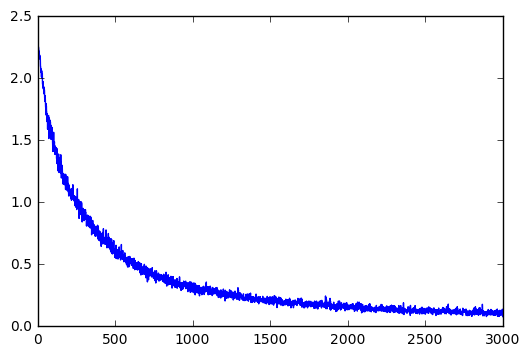

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(loss_track)
print('loss: {:.4f}'.format(loss_track[-1]))